
1. Training Basic XGBoost Model...

Basic XGBoost Results:
  MAE:  12.0031
  RMSE: 15.2456
  R²:   0.2870

2. Hyperparameter Tuning (this may take several minutes)...
Fitting 5 folds for each of 36 candidates, totalling 180 fits

Best Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 150, 'subsample': 0.8}
Best CV R² Score: 0.3107

Tuned XGBoost Results:
  MAE:  11.3801
  RMSE: 14.7652
  R²:   0.3312

3. Generating Feature Importance Plot...
Error creating plot: [Errno 2] No such file or directory: 'figures/xgboost_feature_importance.png'


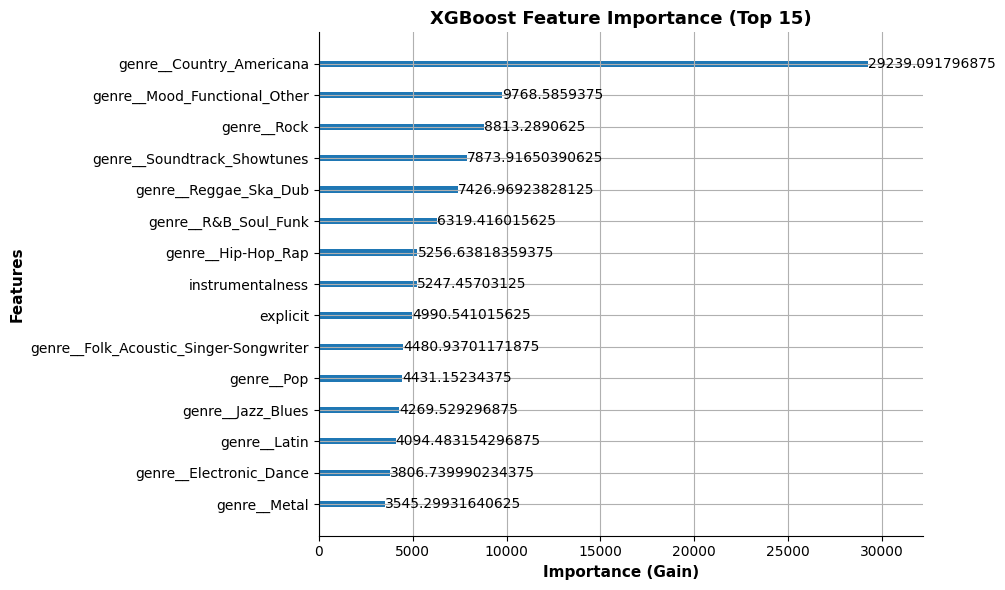

In [1]:
import xgboost as xgb
from utils_io import load_step, save_step
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import os
import warnings
from utils_io import load_step
warnings.filterwarnings('ignore')

y_train = load_step("y_train_nz")
y_test = load_step("y_test_nz")
X_train_scaled = load_step("X_train_nz_scaled")
X_test_scaled = load_step("X_test_nz_scaled")


# 1. Basic XGBoost Model
print("\n1. Training Basic XGBoost Model...")
try:
    xgb_model = xgb.XGBRegressor(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        verbosity=0
    )

    xgb_model.fit(X_train_scaled, y_train)

    y_pred_xgb = xgb_model.predict(X_test_scaled)

    mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
    rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
    r2_xgb = r2_score(y_test, y_pred_xgb)

    print(f"\nBasic XGBoost Results:")
    print(f"  MAE:  {mae_xgb:.4f}")
    print(f"  RMSE: {rmse_xgb:.4f}")
    print(f"  R²:   {r2_xgb:.4f}")
except Exception as e:
    print(f"Error in basic model: {e}")

# 2. Hyperparameter Tuning
print("\n2. Hyperparameter Tuning (this may take several minutes)...")

try:
    param_grid = {
        'n_estimators': [50, 100, 150],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1],
        'subsample': [0.8, 0.9]
    }

    xgb_grid = xgb.XGBRegressor(random_state=42, verbosity=0)

    grid_search = GridSearchCV(
        xgb_grid, 
        param_grid, 
        cv=5, 
        scoring='r2',
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X_train_scaled, y_train)

    print(f"\nBest Parameters: {grid_search.best_params_}")
    print(f"Best CV R² Score: {grid_search.best_score_:.4f}")

    best_xgb = grid_search.best_estimator_
    y_pred_best_xgb = best_xgb.predict(X_test_scaled)

    mae_best = mean_absolute_error(y_test, y_pred_best_xgb)
    rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best_xgb))
    r2_best = r2_score(y_test, y_pred_best_xgb)

    print(f"\nTuned XGBoost Results:")
    print(f"  MAE:  {mae_best:.4f}")
    print(f"  RMSE: {rmse_best:.4f}")
    print(f"  R²:   {r2_best:.4f}")
except Exception as e:
    print(f"Error in tuning: {e}")
    best_xgb = xgb_model
    y_pred_best_xgb = y_pred_xgb

# 3. Feature Importance
print("\n3. Generating Feature Importance Plot...")

try:
    fig, ax = plt.subplots(figsize=(10, 6))
    xgb.plot_importance(best_xgb, max_num_features=15, ax=ax, importance_type='gain')
    ax.set_xlabel('Importance (Gain)', fontweight='bold', fontsize=11)
    ax.set_ylabel('Features', fontweight='bold', fontsize=11)
    ax.set_title('XGBoost Feature Importance (Top 15)', fontweight='bold', fontsize=13)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tight_layout()
    plt.savefig('figures/xgboost_feature_importance.png', dpi=300, bbox_inches='tight')
    print("✓ Feature importance plot saved")
    plt.close()
except Exception as e:
    print(f"Error creating plot: {e}")


